# Twitter Data Analysis.

Extracting Twitter data , Pre-processing and Mining for trending keywords.

With the current COVID-19 pandemic consequences we tried to understand how "recession" is trending over twitter.

In [133]:
import requests
import base64
import nltk
import requests
from nltk.corpus import twitter_samples
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn import naive_bayes
import re 
import pandas as pd
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer 
import gensim
from nltk.corpus import stopwords
from nltk.corpus import words
from nltk import FreqDist

Twitter API Connection.

In [413]:
def search_data_twitter(my_search_term):
    
    client_key = 'XXXX'
    client_secret = 'XXXX'

    key_secret = '{}:{}'.format(client_key, client_secret).encode('ascii')
    b64_encoded_key = base64.b64encode(key_secret)
    b64_encoded_key = b64_encoded_key.decode('ascii')

    base_url = 'https://api.twitter.com/'
    auth_url = '{}oauth2/token'.format(base_url)

    auth_headers = {
        'Authorization': 'Basic {}'.format(b64_encoded_key),
        'Content-Type': 'application/x-www-form-urlencoded;charset=UTF-8'
    }

    auth_data = {
        'grant_type': 'client_credentials'
    }

    auth_resp = requests.post(auth_url, headers=auth_headers, data=auth_data)
    print("Status :",auth_resp.status_code)

    access_token = auth_resp.json()['access_token']

    search_headers = {
        'Authorization': 'Bearer {}'.format(access_token)    
    }

    search_params = {
        'q': my_search_term,
        'result_type': 'recent',
        'count': 200,
        'tweet_mode':'extended',
        'retweeted':'False',
        'iso_language_code': 'en'
    }

    search_url = '{}1.1/search/tweets.json'.format(base_url)

    search_resp = requests.get(search_url, headers=search_headers, params=search_params)
    
    return search_resp

    

In [3]:
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 5000)
pd.set_option('display.width', 10000)

Analyzing the trends in "recession" on Twitter.

In [426]:
data = search_data_twitter('microsoft')
tweet_data = data.json()

Status : 200


In [427]:
#my_tweets = []
for x in tweet_data['statuses']:
    my_tweets.append(x['full_text'])

In [428]:
len(my_tweets)

1000

In [429]:
def clean_data(my_tweets):
    tweet_list = []
    for i in my_tweets:
        proc_tweet = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+#]|[!*\(\),]|'\
                        '(?:%[0-9a-fA-F][0-9a-fA-F]))+','',i)

        proc_tweet = re.sub("(@[A-Za-z0-9_]+)","", proc_tweet)
    
        proc_tweet = proc_tweet.lower()
   
        proc_tweet = re.sub(r'\W', ' ', proc_tweet)

        proc_tweet = re.sub(r'\s+', ' ', proc_tweet, flags=re.I)

        proc_tweet = proc_tweet.replace('rt','')

        proc_tweet = re.findall(r'\w+', proc_tweet) 
        
        tweet_list.append(proc_tweet)
    
    return tweet_list

In [430]:
my_tweets_freq_count = my_tweets.copy()

In [431]:
my_tweets_freq_count = clean_data(my_tweets_freq_count)

# Analyzing Word Frequency.

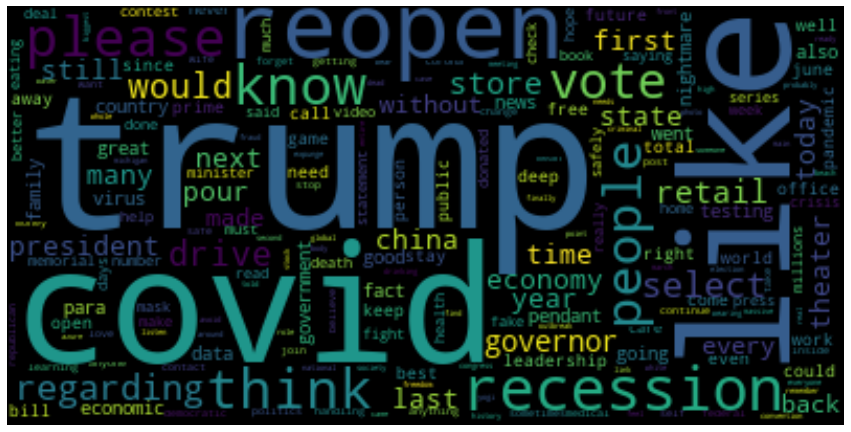

In [432]:
from wordcloud import WordCloud

words = set(nltk.corpus.words.words())
my_clean_list=[]
for i in my_tweets_freq_count:
    for j in i:
        if (j not in stopwords.words('english') and (j in words) and len(j) > 3):
            my_clean_list.append(j)
        
#frequency count
freq_dist_pos = FreqDist(my_clean_list)

wcloud = WordCloud().generate_from_frequencies(freq_dist_pos)
plt.figure(figsize=(15,16))
plt.imshow(wcloud, interpolation="bilinear")
 
plt.axis("off")
(-0.5, 499.5, 499.5, -0.5)

plt.show()

As it can be seen here using the word cloud a lot of inferences can be made on how the TOPIC is being impacted by different factors and also summarizes a lot about the present worst situations.

<br>

# Data Pre-Processing.

In [433]:
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
        
    return input_txt

In [434]:
tweet_3 = pd.DataFrame(my_tweets,columns=['Tweets'])
tweet_3['Real_Tweets']=tweet_3['Tweets']

In [435]:
#lowercase
tweet_3['Tweets'] = tweet_3['Tweets'].str.lower()

#removing the tweets username.
tweet_3['Tweets'] = np.vectorize(remove_pattern)(tweet_3['Tweets'], "@[\w]*")

#removing all the RT: text from the Tweets.
tweet_3['Tweets'] = np.vectorize(remove_pattern)(tweet_3['Tweets'], "RT :")

tweet_3['Tweets'] = tweet_3['Tweets'].str.replace('[^a-zA-Z#]',' ')

tweet_3['Tweets'] = np.vectorize(remove_pattern)(tweet_3['Tweets'], "\n")

#removing links
tweet_3['Tweets'] = np.vectorize(remove_pattern)(tweet_3['Tweets'], "r'^https?:\/\/.*[\r\n]*'")

#removing the emoticons
tweet_3['Tweets'] = tweet_3['Tweets'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

tweet_3['Tweets_len'] = tweet_3['Tweets'].apply(len)

#removing tweets totally in different languages
drop_tweets = tweet_3[tweet_3['Tweets_len'] == 0].index

tweet_3.drop(index=drop_tweets,inplace=True)

#drop duplicates
tweet_3.drop_duplicates(subset=['Tweets'], keep = 'first',inplace= True)

# Preparing data for vectorization.

# Vectorization is a methology of converting the words into real numbers which is used to find the word similarities.

# 1.TF-IDF (TERM FREQUENCY INVERSE DOCUMENT FREQUENCY)



In [436]:
stopset = set(stopwords.words('english'))
desc = tweet_3['Tweets'].values
vectorizer = TfidfVectorizer(stop_words = stopset)
X = vectorizer.fit_transform(desc)

In [437]:
word_features = vectorizer.get_feature_names()

# Clustering of the Vectorized Data.

# 1. K Means Clustering.

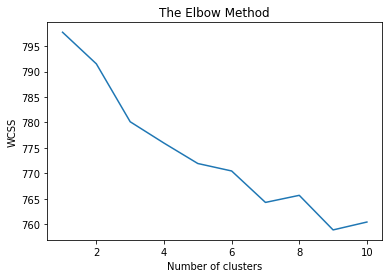

In [438]:
from sklearn.cluster import KMeans

wcss = []
for i in range(1,11):
    kmeans = KMeans(n_clusters=i,init='random',max_iter=100,n_init=10,random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
    
plt.plot(range(1,11),wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.savefig('elbow.png')
plt.show()

In [439]:
kmeans = KMeans(n_clusters = 5, n_init = 20, n_jobs = 1)
kmeans.fit(X)
common_words = kmeans.cluster_centers_.argsort()[:,-1:-26:-1]

Clustering of Data to understand the similarity in the keywords.

In [440]:
for num, centroid in enumerate(common_words):
    print(str(num) + ' : ' + ', '.join(word_features[word] for word in centroid))
    print("")

0 : amazon, https, youtube, prime, google, upip, sknif, listen, gift, kfoeue, itunes, really, book, tudo, vito, brand, list, surprise, orgoogle, shiseido, lijtj, core, facebook, wish, swallowing

1 : counties, california, retail, store, churches, reopen, https, shopping, qolxwjxzxy, hskk, kwaqbkyt, nuvqehj, sprl, dictwltupi, psut, ataqqm, zjwvkdqq, wsmscq, zsssr, uuwrnivrtu, nigfaobise, qtpn, qrimuab, announces, xdkmi

2 : https, trump, covid, microsoft, ramadan, coronavirus, recession, like, people, reopen, would, president, para, economy, donald, back, time, first, deaths, still, says, economic, last, america, many

3 : dominic, cummngs, cummings, dominiccummngs, https, press, right, think, earlier, statement, person, rules, family, going, legally, someone, acted, people, trending, must, health, stay, today, joke, social

4 : modi, narendra, https, yogi, india, year, govt, minister, prime, votes, wrong, colonel, chronicles, nahi, comments, ladakh, congress, china, like, made, call, p

# 2. Word2Vec

In [486]:
tokenized_tweet = tweet_3['Tweets'].apply(lambda x: x.split()) # tokenizing 

In [492]:
tweet_3['Tweets']

0      biden democratic nominee everyone else dropped...
1      believe april from trash paper love president ...
2      best honor gold star families vote draft dodge...
3      nearing deaths from coronavirus without federa...
4      imprensa mundial esquerda trump sofre muito ta...
5      collusion obama #weaponized surveillance laws ...
6      okokok long until sessions steps #cult like tr...
7      years office blames nations problems trump #na...
8      thats dislike liberal democrats much will defi...
9      trump wins election second term will eradicate...
10     biden came basement today shadow looks like fo...
11     this means trump wants have convention trump d...
12     https owycvn fighting deep state fighting swam...
13     nichols oppose trump personal capacity america...
14                hope scarborough sues trump defamation
15     democratic michigan gretchen whitmer said cens...
16     remove bots trolls handful blue checkmarks fin...
17     this worth watch about r

In [493]:
model_w2v = gensim.models.Word2Vec(
            tokenized_tweet,
            size=100, # desired no. of features/independent variables
            window=6, # context window size
            min_count=3, # Ignores all words with total frequency lower than 2.                                  
            sg = 1, # 1 for skip-gram model
            hs = 0,
            negative = 10, # for negative sampling
            workers= 32, # no.of cores
            seed = 34
) 

model_w2v.train(tokenized_tweet, total_examples= len(tweet_3['Tweets']), epochs=20)

(82007, 198420)

In [494]:
from nltk.cluster import KMeansClusterer
from sklearn import cluster
from sklearn import metrics

Z = model_w2v[model_w2v.wv.vocab]

NUM_CLUSTERS=5
kclusterer = KMeansClusterer(NUM_CLUSTERS, distance=nltk.cluster.util.cosine_distance, repeats=25)
assigned_clusters = kclusterer.cluster(Z, assign_clusters=True)
 
words = list(model_w2v.wv.vocab)

kmeans = cluster.KMeans(n_clusters=NUM_CLUSTERS)
kmeans.fit(X)
 
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

/Users/abhishekbidap/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """


In [495]:
my_cluster={}
for i, word in enumerate(words):  
    my_cluster[word] = str(assigned_clusters[i])

from collections import defaultdict 
  
res = defaultdict(list) 
for key, val in sorted(my_cluster.items()): 
    res[val].append(key) 
      
for key,value in dict(res).items():
    print("Group",key,":",value)
    print() 

Group 3 : ['#amazon', '#coronavirus', '#eidmubarak', '#ramadan', 'across', 'actually', 'again', 'agora', 'analysis', 'andrew', 'apple', 'around', 'back', 'barnard', 'based', 'below', 'black', 'body', 'boris', 'both', 'breaking', 'cable', 'calls', 'casi', 'casos', 'castle', 'cession', 'child', 'chinese', 'club', 'como', 'conference', 'contact', 'coronav', 'coronavirus', 'could', 'courts', 'cuarentena', 'cuomo', 'dans', 'data', 'days', 'deep', 'details', 'dias', 'digital', 'doors', 'election', 'este', 'europe', 'explore', 'facebook', 'family', 'fans', 'fasting', 'federal', 'file', 'find', 'fitr', 'freedom', 'from', 'funny', 'general', 'gift', 'gobierno', 'google', 'happening', 'health', 'held', 'here', 'hope', 'hospital', 'india', 'itunes', 'johnson', 'learning', 'liberal', 'link', 'listen', 'marine', 'mart', 'mask', 'mass', 'mexico', 'microsoft', 'minister', 'mode', 'modeling', 'mois', 'momento', 'more', 'move', 'muito', 'music', 'muslims', 'narendra', 'nous', 'office', 'open', 'order',

# Identifying the Similarity between the tweets.

In [515]:
def w2v(s1,s2,wordmodel):
            if s1==s2:
                    return 1.0
            s1words=s1.split()
            s2words=s2.split()
            
            s1wordsset=set(s1words)
            s2wordsset=set(s2words)
            
            vocab = wordmodel.wv.vocab #the vocabulary considered in the word embeddings
         
            for word in s1wordsset.copy(): #remove sentence words not found in the vocab
                    if (word not in vocab):
                            s1words.remove(word)
            for word in s2wordsset.copy(): 
                    if (word not in vocab):
                            s2words.remove(word)
            print(s1words)
            print(s2words)
            return wordmodel.wv.n_similarity(s1words, s2words)

In [539]:
s1=tweet_3['Tweets'][500]
s2=tweet_3['Tweets'][651]

In [540]:
s1

'barnard castle witness calls cummings quit after hearing defence politics guardian https ardvwtairu #cummngs #conservative #borisjohnson https qxzm'

In [541]:
s2

'years never would have thought writing book called rebel millionaire left making'

In [542]:
w2v(s1,s2,model_w2v)

['barnard', 'castle', 'calls', 'cummings', 'after', 'defence', 'politics', 'https', '#cummngs', 'https']
['years', 'never', 'would', 'have', 'thought', 'writing', 'book', 'called', 'left', 'making']


0.9384755